In [1]:
from hmmlearn.hmm import GaussianHMM, MultinomialHMM
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import read_data
from gensim.models import FastText
from copy import deepcopy
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    from imblearn.over_sampling import SMOTE
import pickle
import math
import random

In [2]:
def discretize_protocol(item):
    return list(protocols).index(item)

In [3]:
infected_ips = ['147.32.84.165', '147.32.84.191', '147.32.84.192']
normal_ips = ['147.32.84.170', '147.32.84.134', '147.32.84.164', '147.32.87.36', '147.32.80.9', '147.32.87.11']


ip_to_profile = '147.32.84.165'
data = read_data('datasets/CTU-Malware-Capture-Botnet-52')
data.to_pickle('./data_52.pkl')
# data = pd.read_pickle('./data_52.pkl')

In [4]:
# Used to keep the original data
data_original = deepcopy(data)

In [5]:
# discretize protocol
protocols = set(data.protocol.unique())
data['protocol'] = data['protocol'].apply(lambda x: list(protocols).index(x))

In [6]:
# discretize flags

flags = set(data.flags.unique())
data['flags'] = data['flags'].apply(lambda x: list(flags).index(x))

In [7]:
# discretize label

data['label'] = data['label'].replace('Botnet', 0)
data['label'] = data['label'].replace('LEGITIMATE', 1)

In [8]:
# remove background flows and date

data = data[data['label'] != 'Background']
data.drop(['date'],1, inplace=True)

In [9]:
# replace 'na' values in  src and dst port

data['src_port'] = data['src_port'].replace('na', 0)
data['dst_port'] = data['dst_port'].replace('na', 0)

In [10]:
data.reset_index(inplace=True)
data.head()

,index,duration,protocol,src_ip,src_port,dst_ip,dst_port,flags,tos,packets,bytes,flows,label
0,21,0.000,2,147.32.86.194,3972,173.194.1.27,80,38,0,2,108,1,1
1,22,0.015,2,147.32.86.194,3974,74.125.108.185,80,38,0,2,108,1,1
2,35,0.000,2,147.32.84.28,56781,147.32.80.13,80,165,0,2,132,1,1
3,36,0.117,2,147.32.84.164,57264,64.12.68.227,443,185,0,2,114,1,1
4,37,0.117,2,147.32.84.164,43869,64.12.73.134,443,185,0,2,114,1,1


## Profiling without embeddings

In [11]:
# Chosen IP to profile
chosen = data[(data['src_ip'] == ip_to_profile) | (data['dst_ip'] == ip_to_profile)]


In [12]:
def get_windows(data, window_size):
    curr_data = data.drop(['src_ip', 'dst_ip', 'label'], 1)
    size = len(curr_data) - window_size
    
    # create sliding window data
    win_data = np.zeros((10,size,window_size),dtype=np.float)
    headers = list(curr_data.columns.values)
    for ind, h in enumerate(headers):
        for i in range(size):
            win_data[ind][i] = np.array([flow for flow in curr_data.iloc[i:i+window_size][h].values])
    X = np.concatenate([w for w in win_data])
    lengths = [len(w) for w in win_data]
    return X, lengths

In [13]:
def find_optimal_params(chosen):
    max_ll = -math.inf
    optimal_win = 0
    optimal_components= 0
    for comp in range(2,7):
        for win in  range(2,11):
            win_data, lengths = get_windows(chosen, win)
            hmm = GaussianHMM(n_components=comp)
            hmm.fit(win_data, lengths)
            log_likelihood = hmm.decode(win_data)[0]
            if log_likelihood > max_ll:
                max_ll = log_likelihood
                optimal_win = win
                optimal_components = comp
            print('Window=%d ,Components=%d, Log-likelihood=%.3f' %(win,comp,log_likelihood))
    print('Optimal values: Window=%d, Components=%d' %(optimal_win, optimal_components))
    return optimal_win, optimal_components

### Model the chosen IP

In [14]:
# get the optimal window size and number of components for the HMM
# win, components = find_optimal_params(chosen)
win, components = 4,4

win_data, lengths = get_windows(chosen, win)

# learn a Gaussian Hidden Markov Model with 4 states from the infected host data
hmm = GaussianHMM(n_components=components)
# hmm = MultinomialHMM(n_components=components)
# MultinomialHMM
hmm.fit(win_data, lengths)
# store the log-likelihood of the host that trained the model
log_likelihood = hmm.decode(win_data)[0]

### Compute the log-likelihood of the other hosts (infected and normal) with the examined host 

In [15]:
hosts_log_likelihood = {}
# compute log-likelihood of data sequence of normal IPs
for ip in normal_ips:
    # get the flows of that host only
    host_data = data[(data['src_ip'] == ip) | (data['dst_ip'] == ip)]
    size = len(host_data) - win
    # if host has enough flows for creating a window
    if size > 0:
        # create sliding windows sequences
        normal_data, lengths = get_windows(host_data, win)
        # get the log-likelihood of the sequential data
        hosts_log_likelihood[ip] = hmm.decode(normal_data, lengths)[0]
    else:
        hosts_log_likelihood[ip] = 0

# repeat procedure for all infected IPs
for ip in infected_ips:
    # get the flows of that host only
    host_data = data[(data['src_ip'] == ip) | (data['dst_ip'] == ip)]
    size = len(host_data) - win
    # if host has enough flows for creating a window
    if size > 0:
        # create sliding windows sequences
        infected_data,lengths = get_windows(host_data, win)
        # get the log-likelihood of the sequential data
        hosts_log_likelihood[ip] = hmm.decode(infected_data, lengths)[0]
    else:
        hosts_log_likelihood[ip] = 0

### Plot the log-likelihood for all hosts

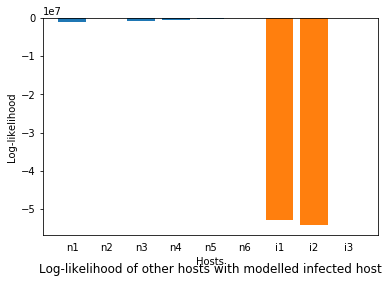

In [16]:
infected_ips = ['147.32.84.165', '147.32.84.191', '147.32.84.192']
normal_ips = ['147.32.84.170', '147.32.84.134', '147.32.84.164', '147.32.87.36', '147.32.80.9', '147.32.87.11']

fig, ax = plt.subplots()
xticks = ['n'+str(i) for i in range(1,7)] + ['i'+str(i) for i in range(1,4)]
h = [v[1] for v in hosts_log_likelihood.items()]
plt.bar(list(range(6)), h[:6])
plt.bar(list(range(6,9)), h[6:])
plt.xlabel('Hosts')
plt.ylabel('Log-likelihood')
plt.title('Log-likelihood of other hosts with modelled infected host',y=-0.2 )
ax.set_xticks([0,1,2,3,4,5,6,7,8])
ax.set_xticklabels(xticks)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off
# plt.savefig('log_likelihood.png',  bbox_inches='tight')
plt.show()

### Identify normal and indected hosts

In [17]:
# evaluate results using the log-likelihood distance of hosts from the one who trained the model
TP = 0
TN = 0
FP = 0
FN = 0
positives = []
negatives = []

# 
dist = {}
for ip in hosts_log_likelihood.keys():
    # absolute log-likelihood distance
    dist[ip] = abs(hosts_log_likelihood[ip] - log_likelihood)

    # threshold is half log-likelihood
    if dist[ip] > abs(log_likelihood / 2):
        negatives.append(ip)
    else:
        positives.append(ip)

# evaluate all potentially malicious hosts
for i in positives:
    if i in infected_ips:
        TP += 1
    else:
        FP += 1

# evaluate all potentially benign hosts
for i in negatives:
    if i in normal_ips:
        TN += 1
    else:
        FN += 1
if TP + FP == 0:
    precision = 0
else:
    precision = TP / (TP + FP)
recall = TP / (TP + FN)
accuracy = (TP + TN) / (TP + TN + FP + FN)
print('True Positives : {}'.format(TP))
print('False Positives : {}'.format(FP))
print('True Negatives : {}'.format(TN))
print('False Negatives : {}'.format(FN))
print('Precision: {}'.format(precision))
print('Recall: {}'.format(recall))
print('Accuracy: {}'.format(accuracy))

True Positives : 2
False Positives : 0
True Negatives : 6
False Negatives : 1
Precision: 1.0
Recall: 0.6666666666666666
Accuracy: 0.8888888888888888


## Profiling with embeddings

In [18]:
def check_infected(val, infected_ips):
    """
    Function to assign labels to instances given their ip
    :param val: the flow to be checked
    :param infected_ips: the list of infected hosts
    :return: 1 if val is in the infected list otherwise 0
    """
    return 1 if val in infected_ips else 0

In [19]:
def embedding_host_level(z):
    x = []
    for i,flow in enumerate(z.iterrows()):
        x.append(list(model.wv[z.iloc[i]].sum(axis=0)))
    x = np.array(x)
    return x.mean(axis=0)

In [20]:
def get_windows_embeddings(data, window_size):
#     curr_data = data.drop(['src_ip', 'dst_ip', 'label'], 1)
    curr_data = deepcopy(data)
    size = len(curr_data) - window_size

    # create sliding window data
    win_data = np.zeros((curr_data.shape[1], size, window_size),dtype=np.float)
    for ind in range(curr_data.shape[1]):
        for i in range(size):
            win_data[ind][i] = np.array(curr_data[i:i+window_size, ind])
            
    X = np.concatenate([w for w in win_data])
    lengths = [len(w) for w in win_data]
    return X, lengths

### Split data for training the FASTTEXT model

In [21]:
# split data for the fasttext model training and testing

data_train, data_test = train_test_split(data, test_size=0.5, stratify=data['label'])

In [22]:
# # train model

# df = data_train.apply(lambda x: ','.join(x.astype(str)), axis=1)
# sent = [row.split(',') for row in df]
# model = FastText(sent, min_count=1, size=50, workers=2, window=3, sg=1)

# # save model
# if not os.path.exists('models'):
#     os.makedirs('models')
# fname = 'models/fasttext.model'
# model.save(fname)

# load trained model
fname = 'models/fasttext.model'
model = FastText.load(fname)

In [23]:
infected_ip = '147.32.84.165'
infected_host_dataset = data[(data['src_ip'] == infected_ip) | (data['dst_ip'] == infected_ip)]


### Function to get the embeddings of all flows for a chosen host

In [24]:
# Build the train data for packet level
def get_embeddings(infected_host_dataset, model):
    packet_x = []

    new_infected_host_dataset = infected_host_dataset.drop('label', 1)
    # new_infected_host_dataset = new_infected_host_dataset.drop('date', 1)

    for i,flow in enumerate(infected_host_dataset.iterrows()):
        packet_x.append(list(model.wv[infected_host_dataset.iloc[i]].sum(axis=0)))

    packet_x = np.array(packet_x)
    return packet_x


In [25]:
X = get_embeddings(infected_host_dataset, model)

### Model the chosen infected host

In [26]:
# get the optimal window size and number of components for the HMM
# win, components = find_optimal_params(chosen)
win, components = 4,4

win_data, lengths = get_windows_embeddings(X, win)

# learn a Gaussian Hidden Markov Model with 4 states from the infected host data
hmm = GaussianHMM(n_components=components)
# hmm = MultinomialHMM(n_components=components)
# MultinomialHMM
hmm.fit(win_data, lengths)
# store the log-likelihood of the host that trained the model
log_likelihood = hmm.decode(win_data)[0]

### Compute the log-likelihood of the other hosts (infected and normal) with the examined host 

In [27]:
hosts_log_likelihood = {}
# compute log-likelihood of data sequence of normal IPs
for ip in normal_ips:
    # get the flows of that host only
    host_data = data[(data['src_ip'] == ip) | (data['dst_ip'] == ip)]
    if not host_data.empty:
        size = len(host_data) - win
        host_data = get_embeddings(host_data, model)
        # if host has enough flows for creating a window
        if size > 0:
            # create sliding windows sequences
            normal_data, lengths = get_windows_embeddings(host_data, win)
            # get the log-likelihood of the sequential data
            hosts_log_likelihood[ip] = hmm.decode(normal_data, lengths)[0]
        else:
            hosts_log_likelihood[ip] = 0

# repeat procedure for all infected IPs
for ip in infected_ips:
    # get the flows of that host only
    host_data = data[(data['src_ip'] == ip) | (data['dst_ip'] == ip)]
    if not host_data.empty:
        size = len(host_data) - win
        host_data = get_embeddings(host_data, model)
        # if host has enough flows for creating a window
        if size > 0:
            # create sliding windows sequences
            infected_data,lengths = get_windows_embeddings(host_data, win)
            # get the log-likelihood of the sequential data
            hosts_log_likelihood[ip] = hmm.decode(infected_data, lengths)[0]
        else:
            hosts_log_likelihood[ip] = 0

### Plot the log-likelihood for all hosts

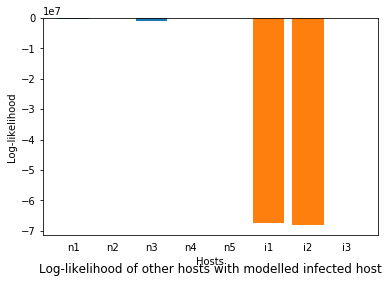

In [28]:
infected_ips = ['147.32.84.165', '147.32.84.191', '147.32.84.192']
normal_ips = ['147.32.84.170', '147.32.84.134', '147.32.84.164', '147.32.87.36', '147.32.80.9', '147.32.87.11']

fig, ax = plt.subplots()
xticks = ['n'+str(i) for i in range(1,6)] + ['i'+str(i) for i in range(1,4)]
h = [v[1] for v in hosts_log_likelihood.items()]
plt.bar(list(range(5)), h[:5])
plt.bar(list(range(5, 8)), h[5:])
plt.xlabel('Hosts')
plt.ylabel('Log-likelihood')
plt.title('Log-likelihood of other hosts with modelled infected host',y=-0.2 )
ax.set_xticks([0,1,2,3,4,5,6,7])
ax.set_xticklabels(xticks)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off
# plt.savefig('log_likelihood.png',  bbox_inches='tight')
plt.show()

### Identify normal and infected hosts

In [29]:
# evaluate results using the log-likelihood distance of hosts from the one who trained the model
TP = 0
TN = 0
FP = 0
FN = 0
positives = []
negatives = []

# 
dist = {}
for ip in hosts_log_likelihood.keys():
    # absolute log-likelihood distance
    dist[ip] = abs(hosts_log_likelihood[ip] - log_likelihood)
    # threshold is half log-likelihood
    if dist[ip] > abs(log_likelihood / 2):
        negatives.append(ip)
    else:
        positives.append(ip)

# evaluate all potentially malicious hosts
for i in positives:
    if i in infected_ips:
        TP += 1
    else:
        FP += 1

# evaluate all potentially benign hosts
for i in negatives:
    if i in normal_ips:
        TN += 1
    else:
        FN += 1
if TP + FP == 0:
    precision = 0
else:
    precision = TP / (TP + FP)
recall = TP / (TP + FN)
accuracy = (TP + TN) / (TP + TN + FP + FN)
print('True Positives : {}'.format(TP))
print('False Positives : {}'.format(FP))
print('True Negatives : {}'.format(TN))
print('False Negatives : {}'.format(FN))
print('Precision: {}'.format(precision))
print('Recall: {}'.format(recall))
print('Accuracy: {}'.format(accuracy))

True Positives : 2
False Positives : 0
True Negatives : 5
False Negatives : 1
Precision: 1.0
Recall: 0.6666666666666666
Accuracy: 0.875
